# 準備

## ライブラリのインポート

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib

import json
import ast
import mca

import GPy

from sklearn.preprocessing import MinMaxScaler

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


## CSVの読み込み

In [4]:
playlist = pd.read_csv("/home/workspace/data/playlist.csv")
playlist.head()

,id,name,knowledge_rule,time_to1,time_from1_to2,time_from2_to3,time_from3,easy_week,small_group,large_group,...,waiwai,scream,dont_move,move,exercise,online,to_2000yen,to_4000yen,to_6000yen,over_6000yen
0,1,バーベキュー,0,0,0,1,1,0,1,1,...,1,0,1,0,0,1,0,1,1,1
1,2,キャンプ・グランピング,0,0,0,0,1,0,1,0,...,1,0,1,1,0,0,0,0,1,1
2,3,温泉・銭湯,0,1,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,4,博物館・美術館,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,5,飲み会(居酒屋),0,0,1,1,1,1,1,1,...,1,0,1,0,0,1,1,1,1,1


In [5]:
playlist.columns

Index(['id', 'name', 'knowledge_rule', 'time_to1', 'time_from1_to2',
       'time_from2_to3', 'time_from3', 'easy_week', 'small_group',
       'large_group', 'indoor', 'outdoor', 'summer', 'winter', 'house', 'town',
       'mountain', 'sea', 'nonbiri', 'waiwai', 'scream', 'dont_move', 'move',
       'exercise', 'online', 'to_2000yen', 'to_4000yen', 'to_6000yen',
       'over_6000yen'],
      dtype='object')

In [6]:
playlist.index = playlist["name"]
playlist = playlist.drop(["name"], axis=1)
playlist

,id,knowledge_rule,time_to1,time_from1_to2,time_from2_to3,time_from3,easy_week,small_group,large_group,indoor,...,waiwai,scream,dont_move,move,exercise,online,to_2000yen,to_4000yen,to_6000yen,over_6000yen
name,,,,,,,,,,,,,,,,,,,,,
バーベキュー,1,0,0,0,1,1,0,1,1,0,...,1,0,1,0,0,1,0,1,1,1
キャンプ・グランピング,2,0,0,0,0,1,0,1,0,0,...,1,0,1,1,0,0,0,0,1,1
温泉・銭湯,3,0,1,1,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
博物館・美術館,4,0,0,1,0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0
飲み会(居酒屋),5,0,0,1,1,1,1,1,1,1,...,1,0,1,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
カメラ撮影,77,1,1,1,0,0,1,1,0,1,...,0,0,1,0,0,0,1,0,0,0
ドライブ,78,0,1,1,0,0,1,1,0,0,...,1,0,1,0,0,0,1,0,0,0
絵画教室,79,0,0,1,0,0,1,1,0,1,...,0,0,1,0,0,1,0,0,1,1


In [7]:
for i, val in enumerate(playlist.values):
    for j, val2 in enumerate(playlist.values[i+1:]):
        if (val == val2).all() :
            print(val)
            print(val2)
            print(playlist.index[i])
            print(playlist.index[i+j+1])
            print("-----------------")

# 多重対応分析の適用

## データ加工

In [8]:
json = playlist.to_json(orient='records')
json

'[{"id":1,"knowledge_rule":0,"time_to1":0,"time_from1_to2":0,"time_from2_to3":1,"time_from3":1,"easy_week":0,"small_group":1,"large_group":1,"indoor":0,"outdoor":1,"summer":1,"winter":1,"house":1,"town":1,"mountain":1,"sea":1,"nonbiri":0,"waiwai":1,"scream":0,"dont_move":1,"move":0,"exercise":0,"online":1,"to_2000yen":0,"to_4000yen":1,"to_6000yen":1,"over_6000yen":1},{"id":2,"knowledge_rule":0,"time_to1":0,"time_from1_to2":0,"time_from2_to3":0,"time_from3":1,"easy_week":0,"small_group":1,"large_group":0,"indoor":0,"outdoor":1,"summer":1,"winter":0,"house":0,"town":0,"mountain":1,"sea":1,"nonbiri":1,"waiwai":1,"scream":0,"dont_move":1,"move":1,"exercise":0,"online":0,"to_2000yen":0,"to_4000yen":0,"to_6000yen":1,"over_6000yen":1},{"id":3,"knowledge_rule":0,"time_to1":1,"time_from1_to2":1,"time_from2_to3":0,"time_from3":0,"easy_week":0,"small_group":1,"large_group":0,"indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":1,"sea":1,"nonbiri":1,"waiwai":0,"scream":0,"don

In [9]:
json = playlist.to_json(orient='records')
json = json.replace('\"', '\'')

In [10]:
json = eval(json)

In [11]:
# json to DataFrame
for i, val in enumerate(json):
    temp = {'calumns': val} 
    input_json = str(temp).replace("'", '"')
    se_json = pd.read_json(input_json) # json to Series
    df_json = se_json if i == 0 else pd.concat([df_json, se_json], axis=1)
df_json  = df_json.reindex(index=json[0].keys())

In [12]:
df_json

,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns,...,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns
id,1,2,3,4,5,6,7,8,9,10,...,72,73,74,75,76,77,78,79,80,81
knowledge_rule,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
time_to1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,1
time_from1_to2,0,0,1,1,1,1,0,0,0,1,...,1,1,1,1,0,1,1,1,1,1
time_from2_to3,1,0,0,0,1,1,0,1,1,1,...,0,1,1,0,0,0,0,0,1,0
time_from3,1,1,0,0,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
easy_week,0,0,0,0,1,1,0,0,0,1,...,0,0,1,0,0,1,1,1,1,1
small_group,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
large_group,1,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
indoor,0,0,1,1,1,1,1,0,1,1,...,0,1,1,1,1,1,0,1,1,1


## データクレイジング

In [13]:
df_json.columns = df_json.loc['id'] # カラム名を遊びIDに変更
#df_json.drop(['created_at','updated_at','name','id'], inplace=True) # いらん情報を削除
df_json.drop(['id'], inplace=True)
df_json = df_json.T # 転置
df_json

,knowledge_rule,time_to1,time_from1_to2,time_from2_to3,time_from3,easy_week,small_group,large_group,indoor,outdoor,...,waiwai,scream,dont_move,move,exercise,online,to_2000yen,to_4000yen,to_6000yen,over_6000yen
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,0,1,1,0,1,...,1,0,1,0,0,1,0,1,1,1
2,0,0,0,0,1,0,1,0,0,1,...,1,0,1,1,0,0,0,0,1,1
3,0,1,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
5,0,0,1,1,1,1,1,1,1,0,...,1,0,1,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1,1,1,0,0,1,1,0,1,1,...,0,0,1,0,0,0,1,0,0,0
78,0,1,1,0,0,1,1,0,0,1,...,1,0,1,0,0,0,1,0,0,0
79,0,0,1,0,0,1,1,0,1,0,...,0,0,1,0,0,1,0,0,1,1


In [14]:
df_json = df_json.reset_index().drop('id',axis=1)

## 多重対応分析の適用

In [15]:
#mca_counts = mca.MCA(playlist)
mca_counts = mca.MCA(df_json.astype(float))
 
# 結果データ抜き出し
# 2次元表示のためN=2まで
rows = mca_counts.fs_r(N=2)  # 表側データ
cols = mca_counts.fs_c(N=2)  # 表頭データ

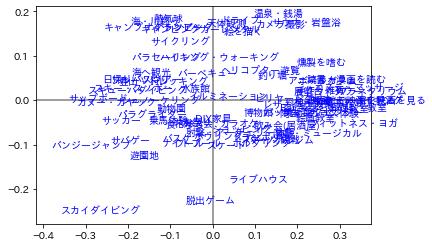

In [16]:
# 表側
plt.scatter(rows[:, 0], rows[:, 1], c='b', marker="None")
labels = playlist.index
for label, x, y in zip(labels, rows[:, 0], rows[:, 1]):
    plt.annotate(label, xy=(x, y), c="b")
    
# 表頭
plt.scatter(cols[:, 0], cols[:, 1], c='r', marker="None")
labels = playlist.columns[1:]
print(len(labels))
for label, x, y in zip(labels, cols[:, 0], cols[:, 1]):
    plt.annotate(label, xy=(x, y), c="r")
 
# xy軸
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')

In [72]:
# 遊び特徴量
fun_features = pd.DataFrame(rows).set_index(playlist.index)
fun_features

,0,1
name,,
バーベキュー,-0.082756,0.055733
キャンプ・グランピング,-0.257319,0.156051
温泉・銭湯,0.096322,0.188736
博物館・美術館,0.072362,-0.032769
飲み会(居酒屋),0.096573,-0.063452
...,...,...
カメラ撮影,0.102633,0.164660
ドライブ,0.018357,0.171998
絵画教室,0.195085,-0.045528


In [73]:
fun_features.to_csv('/home/workspace/data/fun_data.csv', index=True)

## モジュールの確認

In [74]:
%load_ext autoreload
%autoreload 2
from modules import multiple_correspondence_analysis as mca_module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
list(json)

[{'id': 1,
  'knowledge_rule': 0,
  'time_to1': 0,
  'time_from1_to2': 0,
  'time_from2_to3': 1,
  'time_from3': 1,
  'easy_week': 0,
  'small_group': 1,
  'large_group': 1,
  'indoor': 0,
  'outdoor': 1,
  'summer': 1,
  'winter': 1,
  'house': 1,
  'town': 1,
  'mountain': 1,
  'sea': 1,
  'nonbiri': 0,
  'waiwai': 1,
  'scream': 0,
  'dont_move': 1,
  'move': 0,
  'exercise': 0,
  'online': 1,
  'to_2000yen': 0,
  'to_4000yen': 1,
  'to_6000yen': 1,
  'over_6000yen': 1},
 {'id': 2,
  'knowledge_rule': 0,
  'time_to1': 0,
  'time_from1_to2': 0,
  'time_from2_to3': 0,
  'time_from3': 1,
  'easy_week': 0,
  'small_group': 1,
  'large_group': 0,
  'indoor': 0,
  'outdoor': 1,
  'summer': 1,
  'winter': 0,
  'house': 0,
  'town': 0,
  'mountain': 1,
  'sea': 1,
  'nonbiri': 1,
  'waiwai': 1,
  'scream': 0,
  'dont_move': 1,
  'move': 1,
  'exercise': 0,
  'online': 0,
  'to_2000yen': 0,
  'to_4000yen': 0,
  'to_6000yen': 1,
  'over_6000yen': 1},
 {'id': 3,
  'knowledge_rule': 0,
  'time_

In [71]:
mca_module.run(list(json))

KeyError: "['created_at' 'updated_at' 'name'] not found in axis"

# 遊びレコメンドモデル(ガウス過程回帰)の構築

## 遊び特徴量の取得

In [100]:
fun_data = pd.read_csv('/home/workspace/data/fun_data.csv', index_col=0)

In [101]:
fun_data

,0,1
name,,
バーベキュー,-0.082756,0.055733
キャンプ・グランピング,-0.257319,0.156051
温泉・銭湯,0.096322,0.188736
博物館・美術館,0.072362,-0.032769
飲み会(居酒屋),0.096573,-0.063452
...,...,...
カメラ撮影,0.102633,0.164660
ドライブ,0.018357,0.171998
絵画教室,0.195085,-0.045528


In [102]:
fun_name = pd.DataFrame(fun_data.index)
fun_features = fun_data.reset_index(drop=True)

In [76]:
fun_name = pd.DataFrame(fun_data['name'])
fun_features = fun_data.drop('name',axis=1)

KeyError: "['バーベキュー' 'キャンプ・グランピング' '温泉・銭湯' '博物館・美術館' '飲み会(居酒屋)' 'ショッピング' '遊園地' '動物園'\n '水族館' 'カラオケ' '料理・お菓子作り' 'ボルダリング' '海へ観光' '食べ歩き' 'フルーツ狩り' 'アニマルカフェ' 'サッカー'\n 'バスケ' 'バッティングセンター' '映画館で映画を見る' '読書・漫画を読む' '絵を描く' 'レザークラフト' '脱出ゲーム' 'ゲーム'\n 'ボウリング' 'ビリヤード' '麻雀' 'ボードゲーム' 'スポーツ観戦' 'エステ・マッサージ' '家で映画を見る' 'パラグライダー'\n 'スカイダイビング' 'バンジージャンプ' 'カヌー・カヤック' 'サップボード' 'スキューバダイビング' 'シュノーケリング'\n 'ナイトプール' 'パラセーリング' 'ナイトツアー' '海・川釣り' '乗馬体験' 'キャンピングカーレンタル' '天体観測'\n '登山・トレッキング' 'ハイキング・ウォーキング' 'スキー・スノボー' 'Bar' 'サバゲー' 'ビュッフェ・バイキング' 'ライブハウス'\n '演劇・ミュージカル' 'プラネタリウム' 'トランポリン' 'パーソナルジム' 'サイクリング' 'フィットネス・ヨガ'\n '射撃・アーチェリー体験' '陶芸・ガラス体験' 'DIY家具' '手作り雑貨' 'サウナ・岩盤浴' '熱気球' 'ヘリコプター遊覧' 'お祭り'\n '花火大会' '日帰りバスツアー' '料理教室' '占い' 'イルミネーション' 'スケート' 'プール' '釣り堀' '展望台・タワー'\n 'カメラ撮影' 'ドライブ' '絵画教室' '楽器を始める・教室' '燻製を嗜む'] not found in axis"

In [103]:
fun_name

,name
0,バーベキュー
1,キャンプ・グランピング
2,温泉・銭湯
3,博物館・美術館
4,飲み会(居酒屋)
...,...
76,カメラ撮影
77,ドライブ
78,絵画教室
79,楽器を始める・教室


In [105]:
fun_features

,0,1
0,-0.082756,0.055733
1,-0.257319,0.156051
2,0.096322,0.188736
3,0.072362,-0.032769
4,0.096573,-0.063452
...,...,...
76,0.102633,0.164660
77,0.018357,0.171998
78,0.195085,-0.045528
79,0.199601,-0.021659


## 目的変数の取得

In [106]:
y_json = [{"id":1,"hangout_id":19,"fun_score":2},{"id":2,"hangout_id":8,"fun_score":4},{"id":3,"hangout_id":5,"fun_score":5},{"id":4,"hangout_id":13,"fun_score":1},{"id":5,"hangout_id":3,"fun_score":5}]

In [107]:
for i, one_json in enumerate(y_json):
    shaping_json = {"{}".format(i): one_json} 
    input_json = str(shaping_json).replace("'", '"')
    se_y = pd.read_json(input_json) # json to Series
    # 初回だけdfにseを代入し，2回目以降はdfとseを結合する
    df_y = se_y if i == 0 else pd.concat([df_y, se_y], axis=1)
df_y  = df_y.reindex(index=y_json[0].keys()) # indexの順番をjsonと同じにする

In [108]:
df_y.drop(['id'], inplace=True)

In [109]:
df_y = df_y.T
df_y

,hangout_id,fun_score
0,19,2
1,8,4
2,5,5
3,13,1
4,3,5


## 学習セットの作成

In [110]:
x_train = fun_features.loc[df_y['hangout_id']]

In [111]:
x_train

,0,1
19,0.221002,-0.006098
8,-0.076525,0.020352
5,-0.001948,-0.073644
13,-0.110422,-0.060106
3,0.072362,-0.032769


In [112]:
y_train = pd.DataFrame(df_y['fun_score'])
y_train

,fun_score
0,2
1,4
2,5
3,1
4,5


In [113]:
dim = len(x_train.columns)
#kernel = GPy.kern.Matern32(dim) + GPy.kern.Linear(dim) + GPy.kern.Bias(dim) + GPy.kern.White(dim)
#kernel = GPy.kern.RBF(dim) + GPy.kern.Linear(dim) + GPy.kern.Bias(dim) + GPy.kern.White(dim)
kernel = GPy.kern.Matern32(dim) + GPy.kern.Bias(dim) + GPy.kern.White(dim)

model = GPy.models.GPRegression(x_train, y_train, kernel)
model.optimize()

In [114]:
y_qua_pred = model.predict_quantiles(fun_features.values, quantiles=(5, 50, 95))
y_pred = pd.DataFrame(np.array(y_qua_pred).reshape(3,len(y_qua_pred[0])).T)
y_pred.index = fun_features.index
y_pred.columns = ["5%","expected value","95%"]
y_pred.head()

,5%,expected value,95%
0,-0.051726,3.205877,6.463480
1,-0.051752,3.205869,6.463490
2,-0.051735,3.205875,6.463484
3,-0.051721,3.205879,6.463478
4,-0.051722,3.205878,6.463479


In [115]:
def _calc_minmaxscaler(values):
    input_values = values.values.reshape(-1,1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(input_values)

In [116]:
expected_value = y_pred["expected value"]
expected_value_mm = _calc_minmaxscaler(expected_value)
variation = y_pred["95%"] - y_pred["5%"]
variation_mm = _calc_minmaxscaler(variation)

In [130]:
A = 0.5
B = 1 - A
# 期待値が高く,ばらつきが大きい(今までに経験してない)遊びをレコメンドしたい気持ちが込められてる
eval_vals = A * expected_value_mm + B * variation_mm

In [131]:
df_eval_vals = pd.DataFrame(eval_vals, index=y_pred.index, columns=["eval_val"])
df_eval_vals

,eval_val
0,0.487596
1,0.485325
2,0.512234
3,0.505069
4,0.509265
...,...
76,0.511461
77,0.501891
78,0.522660
79,0.522573


In [132]:
df_eval_vals = pd.DataFrame(eval_vals, index=y_pred.index, columns=["eval_val"])

df_eval_vals_sorted = df_eval_vals.sort_values("eval_val", ascending=False)

In [133]:
df_eval_vals_sorted

,eval_val
31,0.549222
54,0.539630
70,0.538347
69,0.536519
58,0.528642
...,...
37,0.479943
38,0.479873
68,0.479841
14,0.479823


In [120]:
y_pred_sort = y_pred.sort_values("95%", ascending=False)
y_pred_sort # 上位5位まで

,5%,expected value,95%
33,-0.051774,3.205863,6.463500
34,-0.051767,3.205865,6.463496
36,-0.051758,3.205867,6.463492
31,-0.051747,3.205872,6.463491
35,-0.051754,3.205869,6.463491
...,...,...,...
71,-0.051723,3.205878,6.463478
3,-0.051721,3.205879,6.463478
61,-0.051722,3.205878,6.463478
5,-0.051721,3.205878,6.463478


## jsonへ 

In [19]:
df_eval_vals

,eval_val
id,
1,0.528736
2,0.622200
3,0.437029
4,0.329580
5,0.501021
6,0.455180
7,0.491716
8,0.219740
9,0.293219


In [20]:
df_eval_vals_sorted

,eval_val
id,
32,0.716896
25,0.644477
2,0.622200
21,0.608637
28,0.590020
11,0.552328
29,0.538103
1,0.528736
31,0.519002


In [24]:
y_pred_json = []
for i, val in enumerate(df_eval_vals_sorted.values.flatten()): 
    y_pred_json.append(dict(hangout_id=df_eval_vals_sorted.index[i], score=val))

In [25]:
y_pred_json

[{'hangout_id': 32, 'score': 0.7168962284131889},
 {'hangout_id': 25, 'score': 0.6444766760109576},
 {'hangout_id': 2, 'score': 0.6221995030100949},
 {'hangout_id': 21, 'score': 0.6086372926375493},
 {'hangout_id': 28, 'score': 0.5900202077994379},
 {'hangout_id': 11, 'score': 0.5523276580806086},
 {'hangout_id': 29, 'score': 0.5381027086078078},
 {'hangout_id': 1, 'score': 0.5287360042786998},
 {'hangout_id': 31, 'score': 0.5190024260288467},
 {'hangout_id': 5, 'score': 0.5010207776634023},
 {'hangout_id': 20, 'score': 0.4954178809190324},
 {'hangout_id': 7, 'score': 0.49171618412262164},
 {'hangout_id': 6, 'score': 0.4551802026380587},
 {'hangout_id': 16, 'score': 0.446045552465143},
 {'hangout_id': 22, 'score': 0.4455208654113463},
 {'hangout_id': 30, 'score': 0.4411940954508893},
 {'hangout_id': 3, 'score': 0.43702885092873067},
 {'hangout_id': 15, 'score': 0.41929762829025463},
 {'hangout_id': 23, 'score': 0.4038102529938008},
 {'hangout_id': 24, 'score': 0.3663574026310419},
 {'h

## モジュールの確認

In [119]:
%load_ext autoreload
%autoreload 2
from modules import fun_recommendation as fr_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
y_json = [{"id":1,"hangout_id":1,"fun_score":5},{"id":2,"hangout_id":2,"fun_score":5},{"id":3,"hangout_id":5,"fun_score":5},{"id":4,"hangout_id":4,"fun_score":1},{"id":5,"hangout_id":3,"fun_score":5}]

In [123]:
fr_model.run(y_json,is_sorted=1)

[{'hangout_id': 32, 'fun_name': '家で映画を見る', 'score': 0.69240244846282},
 {'hangout_id': 15, 'fun_name': 'フルーツ狩り', 'score': 0.6792608633962987},
 {'hangout_id': 6, 'fun_name': 'ショッピング', 'score': 0.6789847758276478},
 {'hangout_id': 7, 'fun_name': '遊園地', 'score': 0.6660420248623409},
 {'hangout_id': 14, 'fun_name': '食べ歩き', 'score': 0.6527113723209459},
 {'hangout_id': 25, 'fun_name': 'ゲーム', 'score': 0.6509060718135158},
 {'hangout_id': 23, 'fun_name': 'レザークラフト', 'score': 0.6216119443013332},
 {'hangout_id': 21, 'fun_name': '読書・漫画を読む', 'score': 0.6097917226708457},
 {'hangout_id': 28, 'fun_name': '麻雀', 'score': 0.6082718551848063},
 {'hangout_id': 11, 'fun_name': '料理', 'score': 0.598042123052897},
 {'hangout_id': 31, 'fun_name': 'エステ・マッサージ', 'score': 0.5737036038617876},
 {'hangout_id': 29, 'fun_name': 'ボードゲーム', 'score': 0.5342546012664958},
 {'hangout_id': 19, 'fun_name': '野球', 'score': 0.5329492539714175},
 {'hangout_id': 17, 'fun_name': 'サッカー', 'score': 0.5329492539714175},
 {'hangout_i

In [48]:
def gpr(X_test, X_train, y_train, kernel):
    N = X_train.shape[0]
    K = np.empty([N, N])
    for n in range(N):
        for m in range(N):
            K[n, m] = kernel(X_train[n], X_train[m])
    K_inv = np.linalg.inv(K)
    yy = K_inv @ y_train
    M = X_test.shape[0]
    mu = np.empty(M)
    var = np.empty(M)
    for m in range(M):
        k = np.empty(N)
        for n in range(N):
            k[n] = kernel(X_train[n], X_test[m])
        s = kernel(X_test[m], X_test[m])
        mu[m] = np.dot(k, yy)
        var[m] = s - k @ K_inv @ np.transpose(k)
    return mu, var

In [67]:
N = 5
lb = -3.0
ub = 3.0
sigma = 0.5

def f(x):
    return np.sin(x)

X_train = np.random.uniform(lb, ub, N)
y_train = f(X_train) + np.random.normal(scale=sigma, size=N)

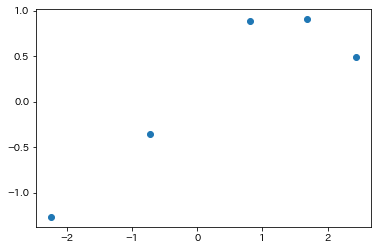

In [68]:
plt.plot(X_train, y_train, "o")

In [69]:
M = 50
X_test = np.linspace(lb, ub)

In [70]:
def gauss_kernel(x1, x2, theta1=0.7, theta2=0.7):
    return theta1 * np.exp(-np.linalg.norm(x1 - x2) / theta2)

In [71]:
mu, var = gpr(X_test, X_train, y_train, gauss_kernel)

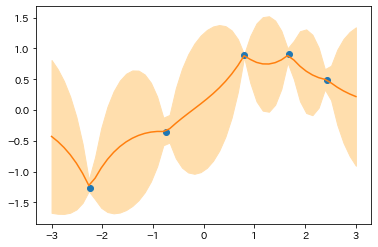

In [72]:
plt.plot(X_train, y_train, "o")
plt.plot(X_test, mu)
plt.fill_between(X_test, mu - 2.0 * var, mu + 2.0 * var, color="navajowhite")